In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
from tensorflow.keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

2025-06-08 01:56:08.886459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749347769.140459      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749347769.211387      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
train_labels_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
test_labels_file = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

# Histopathologic Cancer Detection - CNN

The objective is to develop an algorithm capable of identifying metastatic cancer in small image patches extracted from larger digital pathology scans. This algorithm should then predict the probability that a 32x32 pixel region within a patch contains at least one pixel of tumor tissue.

Dataset Structure
Dataset consists of two main folders (train & test) and one CSV file for labels:

* train/ – Contains labeled histopathologic images.
* test/ – Contains unlabeled images for predictions.
* train_labels.csv – A CSV file mapping image IDs to labels (0 = benign, 1 = malignant).

# EDA

In [ ]:
train_labels = pd.read_csv(train_labels_file)
test_labels = pd.read_csv(test_labels_file)

num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
num_labels = train_labels.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of labeled images: {num_labels}")

Number of training images: 220025
Number of test images: 57458
Number of labeled images: 220025


In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
img = Image.open(sample_image_path)

print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")

img_array = np.array(img)
print(f"Image shape: {img_array.shape}")

Image size: (96, 96)
Image mode: RGB
Image shape: (96, 96, 3)


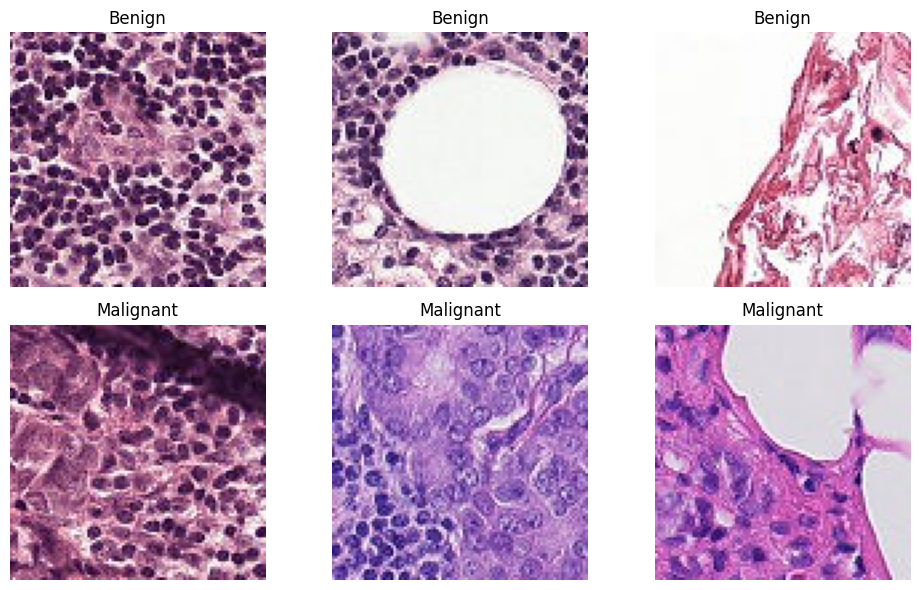

In [ ]:
benign_samples = train_labels[train_labels["label"] == 0].sample(3)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(3)["id"].values

fig, axes = plt.subplots(2, 3, figsize=(10,6))

for i, img_id in enumerate(benign_samples):
    img_path = os.path.join(train_dir, img_id + ".tif")
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Benign")

for i, img_id in enumerate(malignant_samples):
    img_path = os.path.join(train_dir, img_id + ".tif")
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Malignant")

plt.tight_layout()
plt.show()

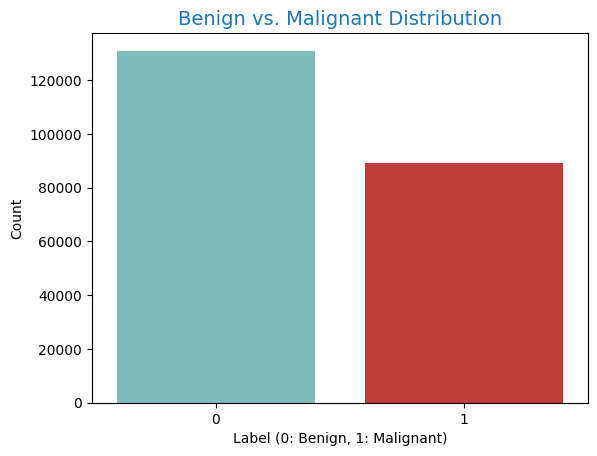

In [ ]:
sns.countplot(x=train_labels['label'], palette=["#76c7c0", "#d62728"])
plt.title("Benign vs. Malignant Distribution", fontsize=14, color="#1f77b4")
plt.xlabel("Label (0: Benign, 1: Malignant)")
plt.ylabel("Count")
plt.show()

The dataset is imbalanced, with a higher number of benign (0) samples compared to malignant (1) samples. To address this imbalance during model training, we may consider data augmentation or class weighting.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


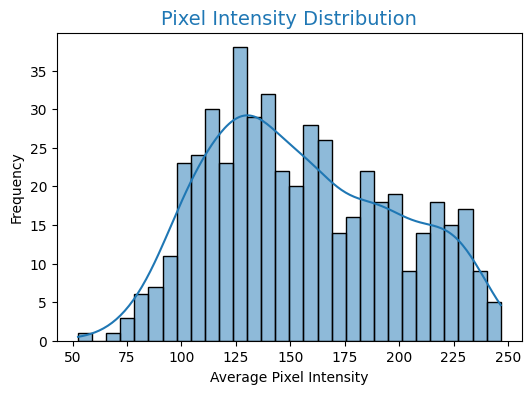

In [ ]:
sample_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)[:500]]  # Sample 500 images

intensities = []
for img_path in sample_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    intensities.append(np.mean(img))  # Compute mean intensity

plt.figure(figsize=(6,4))
sns.histplot(intensities, bins=30, color="#1f77b4", kde=True)
plt.title("Pixel Intensity Distribution", fontsize=14, color="#1f77b4")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

The intensity histogram shows a wide range of brightness levels, indicating diverse staining conditions in pathology slides. Preprocessing (normalization, contrast enhancement) may improve model performance.

# Data Cleaning and Image Preprocessing

In [ ]:
missing_values = train_labels.isnull().sum()
print(missing_values)


id       0
label    0
dtype: int64


In [ ]:
duplicates = train_labels.duplicated().sum()
print(f"Duplicate entries: {duplicates}")

Duplicate entries: 0


In [ ]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + iid + ".tif"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
n_train_subset = int(train_labels.shape[0]*0.05)

negative = train_labels[train_labels['label'] == 0].sample(n_train_subset)
positive = train_labels[train_labels['label'] == 1].sample(n_train_subset)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)

train_labels_subset = neg_and_pos.sample(frac=1).reset_index(drop=True)

In [ ]:
X_subset = np.array([load_image(i) for i in train_labels_subset['id']])
y_subset = train_labels_subset['label'].values

# Model

We will employ Dropout to prevent overfitting and MaxPooling to reduce the size of the feature map. Additionally, the image will undergo rescaling and cropping to a size of 32x32 pixels.

Let’s compare two simple CNN models:

# Model 1

In [ ]:
def build_model_1(hp):
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Rescaling(1./255),
        Cropping2D(cropping=32),

        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(hp.Int("conv_units", 64, 128, step=64), (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(hp.Int("dense_units", 128, 256, step=128), activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),
                  loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

cnn_1_tuner = kt.RandomSearch(
    build_model_1,
    objective="val_accuracy",
    directory="tuning_1"
)

cnn_1_tuner.search(X_subset, y_subset, validation_split=0.2, epochs=10)

Trial 8 Complete [00h 02m 41s]
val_accuracy: 0.7673255801200867

Best val_accuracy So Far: 0.7739149928092957
Total elapsed time: 00h 26m 48s


In [ ]:
cnn_1_tuner.results_summary()

Results summary
Results in tuning_1/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.001
Score: 0.7739149928092957

Trial 03 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.0001
Score: 0.7727789282798767

Trial 02 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.0001
Score: 0.7709611654281616

Trial 06 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.0001
Score: 0.7705066800117493

Trial 07 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.0001
Score: 0.7673255801200867

Trial 01 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.001
Score: 0.7661895155906677

Trial 04 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.001
Score: 0.7659623026847839

Trial 00 summary
Hyperparameters:
conv_units: 128
dense_units: 256
lea

In [ ]:
cnn_1_model = cnn_1_tuner.get_best_models(num_models=1)[0]
cnn_1_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609,729 (2.33 MB)

 Trainable params: 609,729 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

# Model 2

In [ ]:
def build_model_2(hp):
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Rescaling(1./255),
        Cropping2D(cropping=32),

        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(hp.Int("dense", 64, 128, step=64), activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),
                  loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

cnn_2_tuner = kt.RandomSearch(
    build_model_2,
    objective="val_accuracy",
    directory="tuning_2"
)

cnn_2_tuner.search(X_subset, y_subset, validation_split=0.2, epochs=10)

Trial 4 Complete [00h 04m 23s]
val_accuracy: 0.7714155912399292

Best val_accuracy So Far: 0.7759600281715393
Total elapsed time: 00h 18m 07s


In [ ]:
cnn_2_tuner.results_summary()

Results summary
Results in tuning_2/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
dense: 64
learning_rate: 0.0001
Score: 0.7759600281715393

Trial 03 summary
Hyperparameters:
dense: 128
learning_rate: 0.001
Score: 0.7714155912399292

Trial 01 summary
Hyperparameters:
dense: 64
learning_rate: 0.001
Score: 0.7711883783340454

Trial 00 summary
Hyperparameters:
dense: 128
learning_rate: 0.0001
Score: 0.7700522541999817


In [ ]:
cnn_2_model = cnn_2_tuner.get_best_models(num_models=1)[0]
cnn_2_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,041 (496.25 KB)

 Trainable params: 126,593 (494.50 KB)

 Non-trainable params: 448 (1.75 KB)

Model 2, despite having a reduced parameter count, achieved a marginally higher validation accuracy. This observation suggests that Model 1 may be exhibiting overfitting, potentially due to the substantial increase in parameters without corresponding performance enhancement. In contrast, Model 2 demonstrates greater efficiency, demonstrating improved generalization capabilities with a reduced parameter set while simultaneously maintaining or surpassing accuracy.

Let us proceed with training Model 2 on the complete dataset. To mitigate the risk of extreme overfitting, we will employ the EarlyStopping and ReduceLROnPlateau (learning rate reduction) techniques.

In [ ]:
X = np.array([load_image(i) for i in train_labels['id']])
y = train_labels['label'].values

In [ ]:
# reduce the learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.5,
                                            patience=5,
                                            min_lr=1e-5)

earlystop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          restore_best_weights=True)

In [ ]:
best_hps = cnn_2_tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model_2(best_hps)

In [ ]:
history = best_model.fit(X, y,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[learning_rate_reduction, earlystop])

Epoch 1/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 266s 47ms/step - accuracy: 0.7395 - auc: 0.7937 - loss: 0.5537 - val_accuracy: 0.7915 - val_auc: 0.8595 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 2/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 261s 47ms/step - accuracy: 0.7900 - auc: 0.8540 - loss: 0.4644 - val_accuracy: 0.7923 - val_auc: 0.8707 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 3/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 260s 47ms/step - accuracy: 0.7985 - auc: 0.8643 - loss: 0.4478 - val_accuracy: 0.8076 - val_auc: 0.8823 - val_loss: 0.4263 - learning_rate: 1.0000e-04
Epoch 4/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 260s 47ms/step - accuracy: 0.8112 - auc: 0.8763 - loss: 0.4293 - val_accuracy: 0.8214 - val_auc: 0.8894 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 5/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 262s 48ms/step - accuracy: 0.8176 - auc: 0.8854 - loss: 0.4135 - val_accuracy: 0.7725 - val_auc: 0.8665 - val_loss: 0.5179 - learning_rate: 1.0000e-04
Epoch 6/50
5501/5501 ━━━━━━━━━━━━━━

# Evaluation

**Accuracy Curve**

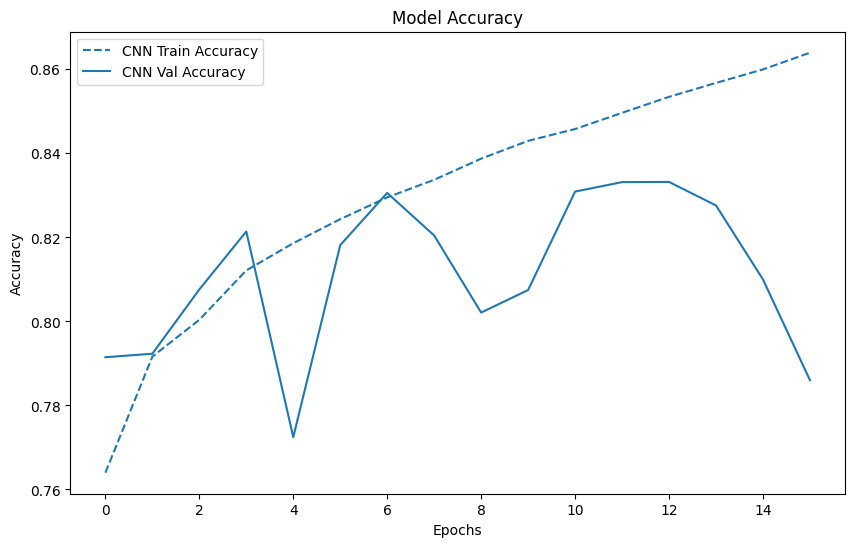

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='CNN Train Accuracy', color='#1f77b4', linestyle="dashed")
plt.plot(history.history['val_accuracy'], label='CNN Val Accuracy', color='#1f77b4')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

* The training accuracy steadily increases over epochs.
* The validation accuracy fluctuates more but follows an upward trend.

**Loss Curve**

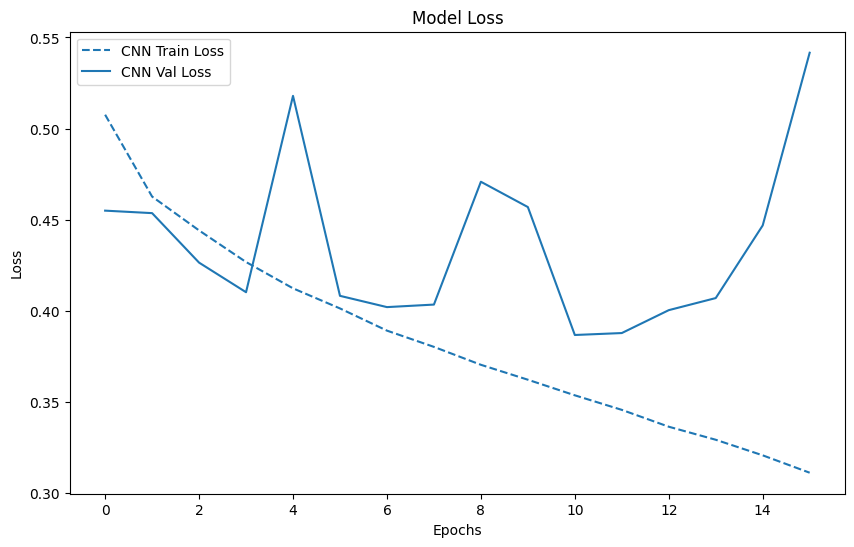

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='CNN Train Loss', color='#1f77b4', linestyle="dashed")
plt.plot(history.history['val_loss'], label='CNN Val Loss', color='#1f77b4')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

* The training loss consistently decreases, indicating the model is learning.
* The validation loss is erratic, showing spikes at different points.

**ROC-AUC Curve**

In [ ]:
n = int(X.shape[0]*0.2)

X_val = X[:n]
y_val = y[:n]

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step


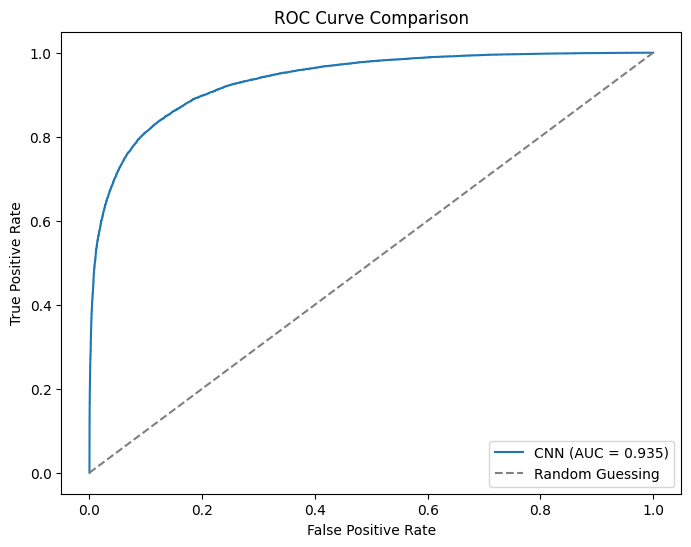

In [ ]:
def plot_roc_curve(model_name, y_true, y_pred, color):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{model_name} (AUC = {roc_auc:.3f})")

# Get true labels and predictions
y_cnn = best_model.predict(X_val)
y_cnn = y_cnn.ravel()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plot_roc_curve("CNN", y_val, y_cnn, "#1f77b4")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

* The ROC curve shows strong performance, with an AUC of 0.935.
* The model is much better than random guessing (dashed line).
* The high AUC suggests that the model can effectively distinguish between the two classes.


# Test Results

In [ ]:
test_labels.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
X_test = np.array([load_image(i, image_dir=test_dir) for i in test_labels['id']])

In [ ]:
y_pred_cnn = best_model.predict(X_test)
y_pred_cnn = y_pred_cnn.ravel()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step


In [ ]:
submission_cnn_df = pd.DataFrame({
            'id':test_labels["id"],
            'label':y_pred_cnn })
submission_cnn_df.to_csv('submission_cnn.csv', index=False)

# **Conclusion**

**Model Performance Analysis**


*   Model 1: 609,729 parameters, Validation Accuracy: 0.773
*   Model 2: 127,041 parameters, Validation Accuracy: 0.775

Despite having significantly fewer parameters, Model 2 slightly outperformed Model 1 in validation accuracy. This suggests that Model 1 might have been overfitting, as its higher complexity.

**Insights from Training Metrics**

Analyzing the accuracy and loss plots, we observe that the train accuracy consistently increases, while the validation accuracy fluctuates more. This fluctuation could indicate some instability or overfitting in the model. Additionally, the validation loss exhibits significant spikes, suggesting that the model encountered challenges during specific epochs.

**Key Learnings**

*What factors contributed to the improvement in performance?*

*   Reducing Model Complexity: Model 2 performed better with fewer parameters, thereby minimizing the risk of overfitting.
*   Regularization techniques effectively prevented extreme overfitting.


*What didn’t help much was?*
*   Increasing model size (Model 1) – More parameters didn’t necessarily improve validation accuracy.
*   Validation fluctuations – This suggests instability in training, possibly due to hyperparameter settings or dataset imbalance.
*   Noisy loss trends – Validation loss spikes indicate room for better tuning.